In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
print(mpl.style.available)

for backends in [['CPU'],['GPU']]:
    if backends == ['GPU']:
        popstrings =    ["setup", "rotation"] + \
                        [ "Type conversion"] + \
                        ["nuFFT init", "FFTshift"] + \
                        ["spin-1 synth"] + \
                        ["Transfers ->", "Transfer <-"] #+ \
                        # ["dlm2pointing", "dlm2pointing - dlm scaling", "dlm2pointing - allocation"] +\
                        
        solvers = ['cufinufft']
        data = []
        lmaxs = np.array([2**n-1 for n in np.arange(11,13)])
        for lmax in lmaxs:
            with open('/mnt/home/sbelkner/git/pySHT/test/benchmark/timings/{backends}_{solver}_{lmax}'.format(backends=backends[0], solver=solvers[0], lmax=lmax), "r") as file:
                data.append(json.load(file))
        for popstring in popstrings:
            if popstring in data[0]:
                data[0].pop(popstring)
        keys_GPU = data[0].keys()
        data_across_l = {}
        for d in data:
            for keyi, key in enumerate(keys_GPU):
                if key in data_across_l:
                    data_across_l[key].append(d[key])
                else:
                    data_across_l[key] = [d[key]]
        resGPU = np.array([v for k, v in data_across_l.items()])           
    else:
        popstrings =    ["setup", "rotation"] +\
                        ["spin-1 maps"] #+\
                        # ["pointing"]
        backend = ['CPU']
        solvers = ['duccnufft'] # duccnufft lenspyx
        d = []
        lmaxs = np.array([2**n-1 for n in np.arange(11,13)])
        data = []
        for lmax in lmaxs:
            with open('/mnt/home/sbelkner/git/pySHT/test/benchmark/timings/{backends}_{solver}_{lmax}'.format(backends=backends[0], solver=solvers[0], lmax=lmax), "r") as file:
                data.append(json.load(file))
        for popstring in popstrings:
            if popstring in data[0]:
                data[0].pop(popstring)
        keys_CPU = data[0].keys()
        data_across_l = {}
        for d in data:
            for keyi, key in enumerate(keys_CPU):
                if key in data_across_l:
                    data_across_l[key].append(d[key])
                else:
                    data_across_l[key] = [d[key]]
        resCPU = np.array([v for k, v in data_across_l.items()]) 

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


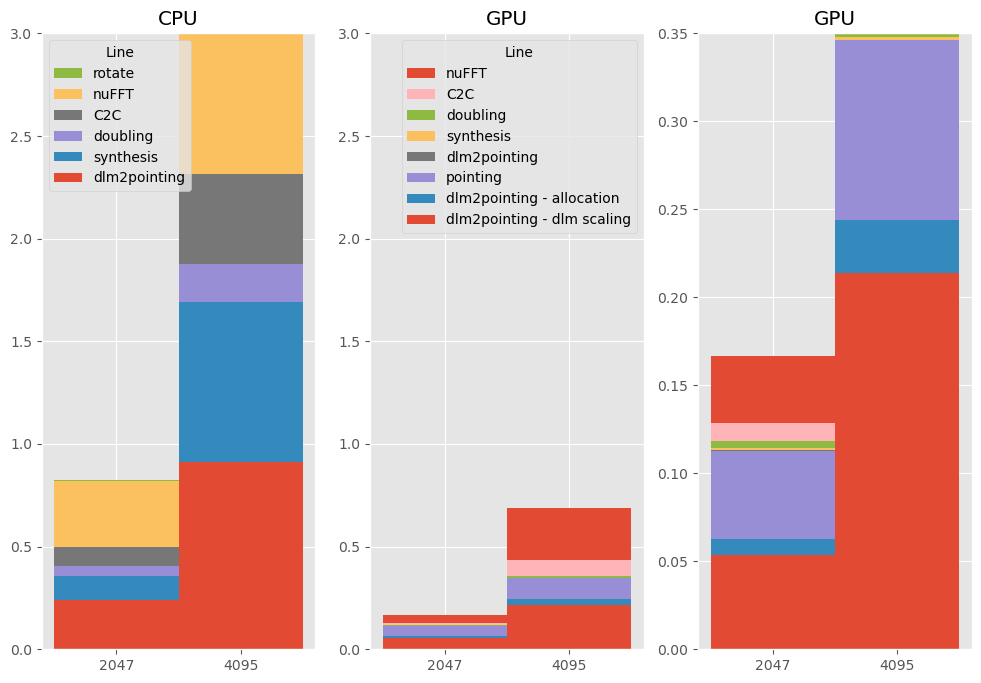

In [30]:
fig, ax = plt.subplots(1,3,figsize=(12,8), sharey=False)
bottom = np.zeros(shape=(len(lmaxs)))
# lmaxs.astype(str)
for rowi, row in enumerate(resCPU): #[:-1,:]
    # if rowi == 0:
        # ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')    
    ax[0].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_CPU)[rowi])
    bottom+=row
ax[0].legend()
ax[0].set_title("CPU")
ax[0].set_ylim(0.0,3)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

bottom = 0
# for rowi, row in enumerate(np.roll(resGPU,-1,axis=0)): #[:-1,:]
for rowi, row in enumerate(resGPU): #[:-1,:]
    ax[1].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_GPU)[rowi])
    bottom+=row
ax[1].legend()
ax[1].set_title("GPU")
ax[1].set_ylim(0.0, 3)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper right')


bottom = 0
# for rowi, row in enumerate(np.roll(resGPU,-1,axis=0)): #[:-1,:]
for rowi, row in enumerate(resGPU): #[:-1,:]
    ax[2].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_GPU)[rowi])
    bottom+=row
# ax[2].legend()
ax[2].set_title("GPU")
ax[2].set_ylim(0.0, 0.35)
handles, labels = ax[1].get_legend_handles_labels()
# ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')

In [31]:
resGPU, list(keys_GPU)

(array([[5.37176132e-02, 2.13990211e-01],
        [9.10711288e-03, 2.96814442e-02],
        [5.00521660e-02, 1.02364302e-01],
        [8.60691071e-05, 1.05619431e-04],
        [1.37662888e-03, 1.70660019e-03],
        [4.11391258e-03, 9.01961327e-03],
        [1.03724003e-02, 7.85408020e-02],
        [3.77960205e-02, 2.50409365e-01]]),
 ['dlm2pointing - dlm scaling',
  'dlm2pointing - allocation',
  'pointing',
  'dlm2pointing',
  'synthesis',
  'doubling',
  'C2C',
  'nuFFT'])

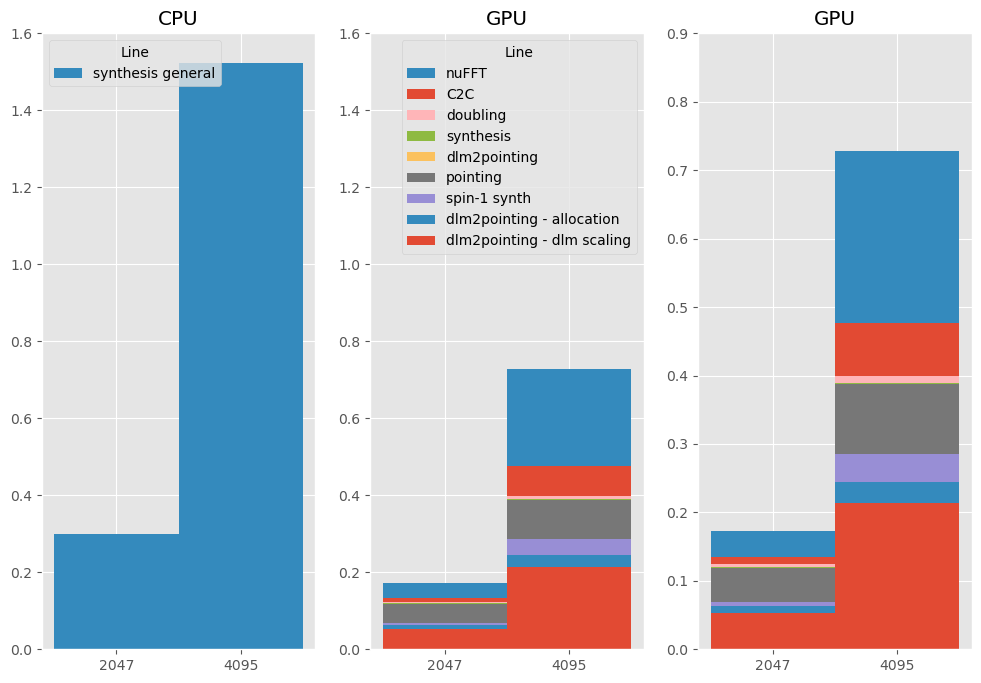

In [37]:
fig, ax = plt.subplots(1,3,figsize=(12,8), sharey=False)
bottom = np.zeros(shape=(len(lmaxs)))
# lmaxs.astype(str)
for rowi, row in enumerate(resCPU): #[:-1,:]
    if rowi == 0:
        ax[0].bar(lmaxs.astype(str), [0,0], 1, align='center', bottom=bottom, label='_')    
    ax[0].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_CPU)[rowi])
    bottom+=row
ax[0].legend()
ax[0].set_title("CPU")
ax[0].set_ylim(0.0,1.6)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')

bottom = 0
# for rowi, row in enumerate(np.roll(resGPU,-1,axis=0)): #[:-1,:]
for rowi, row in enumerate(resGPU): #[:-1,:]
    ax[1].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_GPU)[rowi])
    bottom+=row
ax[1].legend()
ax[1].set_title("GPU")
ax[1].set_ylim(0.0, 1.6)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], title='Line', loc='upper right')


bottom = 0
# for rowi, row in enumerate(np.roll(resGPU,-1,axis=0)): #[:-1,:]
for rowi, row in enumerate(resGPU): #[:-1,:]
    ax[2].bar(lmaxs.astype(str), row, 1, align='center', bottom=bottom, label=list(keys_GPU)[rowi])
    bottom+=row
# ax[2].legend()
ax[2].set_title("GPU")
ax[2].set_ylim(0.0, 0.9)
handles, labels = ax[1].get_legend_handles_labels()
# ax[2].legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')

In [21]:
resCPU[3]/resCPU[0], resGPU[1]/resGPU[2], resCPU[3]/resGPU[1], resCPU[0]/resGPU[2]

(array([2.56211022, 2.72384167]),
 array([3.04827656, 2.75220372]),
 array([40.87254092, 48.46404051]),
 array([48.62819996, 48.96867325]))